In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy
from tqdm import tqdm

plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
PATH = "../data/"

def load_data(data_path):
    returns=pd.read_csv(data_path+'prices.txt',index_col=0)
    assets=np.array(returns.columns)
    dates=np.array(returns.index)
    prices=returns.as_matrix()
    return assets, dates, prices

assets, dates, prices = load_data(PATH)

In [4]:
assets, len(assets)

(array(['AGG', 'DBC', 'DFE', 'DIA', 'DXJ', 'EEM', 'EFA', 'EWG', 'EWH',
        'EWI', 'EWT', 'EWU', 'EWW', 'EWY', 'EWZ', 'EZU', 'FEZ', 'FXI',
        'GDX', 'GLD', 'IAU', 'IBB', 'ITB', 'IVV', 'IWD', 'IWM', 'IYR',
        'KBE', 'KRE', 'LQD', 'OIL', 'SDS', 'SH', 'SLV', 'SPY', 'USO',
        'VGK', 'VNQ', 'VTI', 'VWO', 'XHB', 'XLB', 'XLE', 'XLF', 'XLI',
        'XLK', 'XLP', 'XLU', 'XLV', 'XLY', 'XME', 'XOP', 'USDOLLAR'],
       dtype=object), 53)

In [5]:
dates, len(dates)

(array(['2007-01-02', '2007-01-03', '2007-01-04', ..., '2016-12-02',
        '2016-12-05', '2016-12-06'], dtype=object), 2521)

In [6]:
prices.shape

(2521, 53)

## Some mandatory data cleaning/checking

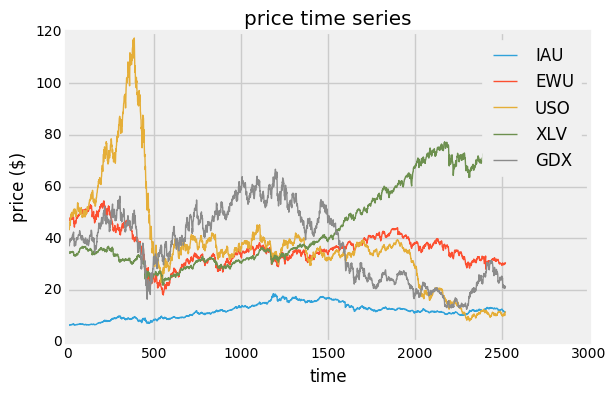

In [7]:
# plot 5 random assets

random_assets = np.random.choice(np.arange(len(assets)), size=5, replace=False)

for a in random_assets:
    plt.plot(prices[:, a], lw=1, label = assets[a])

plt.ylabel("price ($)")
plt.xlabel("time")
plt.title("price time series")
plt.legend()

In [8]:
# any weird null values in there?
np.any(np.isnan(prices.flatten()))

False

In [9]:
price_df = pd.DataFrame(prices, columns = assets, index = pd.to_datetime(dates))
price_df.head()

,AGG,DBC,DFE,DIA,DXJ,EEM,EFA,EWG,EWH,EWI,...,XLF,XLI,XLK,XLP,XLU,XLV,XLY,XME,XOP,USDOLLAR
2007-01-02,99.91,23.80,65.66,124.47,55.28,38.34,73.51,27.15,16.16,33.42,...,36.92,35.23,23.33,26.29,36.82,33.50,38.52,47.66,36.64,10001.976
2007-01-03,99.91,23.80,65.66,124.47,55.28,38.34,73.51,27.15,16.16,33.42,...,36.92,35.23,23.33,26.29,36.82,33.50,38.52,47.66,36.64,10003.944
2007-01-04,100.12,23.18,65.60,124.68,55.95,37.81,73.32,27.06,15.99,33.34,...,36.80,35.08,23.69,26.33,36.77,33.88,38.51,47.42,36.16,10005.909
2007-01-05,100.05,23.20,65.02,123.74,54.78,36.71,72.20,26.61,15.87,32.91,...,36.49,34.96,23.50,26.14,36.11,33.69,38.25,47.01,36.50,10007.878
2007-01-08,100.11,23.22,65.26,124.14,54.86,36.97,72.30,26.53,16.27,32.95,...,36.67,35.09,23.57,26.18,36.09,33.73,38.31,47.49,36.66,10009.860


In [10]:
price_df.describe()

,AGG,DBC,DFE,DIA,DXJ,EEM,EFA,EWG,EWH,EWI,...,XLF,XLI,XLK,XLP,XLU,XLV,XLY,XME,XOP,USDOLLAR
count,2521.000000,2521.000000,2521.000000,2521.000000,2521.000000,2521.000000,2521.000000,2521.000000,2521.000000,2521.000000,...,2521.000000,2521.000000,2521.000000,2521.000000,2521.000000,2521.000000,2521.000000,2521.000000,2521.000000,2521.000000
mean,106.528342,24.532098,47.440809,135.453146,43.629223,39.876795,59.875557,25.418033,18.141365,17.885196,...,20.131257,40.288493,29.729532,35.546581,37.603138,44.496101,48.159349,44.861674,48.985188,10585.883004
std,4.280710,6.176222,12.685294,30.110264,8.008168,6.028587,9.986135,4.758825,3.038246,7.057455,...,6.689001,11.015644,8.750536,9.813023,6.357917,16.531174,19.065278,16.839069,12.767769,127.435157
min,88.400000,11.880000,19.590000,65.440000,28.760000,18.260000,31.700000,12.730000,8.510000,9.280000,...,6.180000,15.360000,13.190000,19.410000,22.740000,21.880000,16.110000,11.970000,23.010000,10001.976000
25%,102.950000,21.370000,36.980000,113.740000,36.550000,37.290000,53.630000,21.910000,16.260000,13.260000,...,14.800000,32.840000,23.200000,27.320000,31.970000,31.670000,32.580000,31.370000,38.810000,10602.166000
50%,107.720000,25.310000,47.040000,130.480000,42.990000,40.740000,58.850000,25.680000,18.720000,15.500000,...,19.830000,37.640000,27.020000,32.040000,37.710000,36.160000,40.420000,42.480000,48.940000,10628.717000
75%,110.020000,27.650000,56.590000,164.080000,49.920000,43.440000,65.840000,29.000000,20.290000,18.580000,...,23.750000,51.750000,37.770000,44.400000,42.370000,59.980000,66.210000,56.240000,57.860000,10646.145000
max,113.250000,46.440000,76.380000,192.490000,60.520000,55.670000,86.100000,36.500000,24.520000,36.360000,...,38.020000,62.880000,48.070000,55.710000,52.980000,77.220000,82.980000,94.580000,83.450000,10683.036000


In [11]:
# could there be a gap in my data date-wise?
all_days = pd.date_range(np.min(price_df.index), np.max(price_df.index))

np.mean(pd.Series(all_days).isin(price_df.index))

0.6950647918389854

Good enough coverage. We are looking for 5/7 type ratio (market is open Monday through Friday)

In [12]:
5/7

0.7142857142857143

In [13]:
# check for outliers based on the daily change in the prices

perc_change_desc = price_df.pct_change().dropna().describe()
perc_change_desc

,AGG,DBC,DFE,DIA,DXJ,EEM,EFA,EWG,EWH,EWI,...,XLF,XLI,XLK,XLP,XLU,XLV,XLY,XME,XOP,USDOLLAR
count,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,...,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2.520000e+03
mean,0.000037,-0.000083,0.000041,0.000247,0.000074,0.000190,0.000030,0.000143,0.000256,0.000196,...,0.000075,0.000331,0.000370,0.000301,0.000165,0.000345,0.000406,0.000225,0.000380,2.614239e-05
std,0.003375,0.012963,0.015516,0.012230,0.015393,0.021044,0.015886,0.018317,0.017682,0.028807,...,0.022843,0.014225,0.013369,0.008903,0.011890,0.011069,0.014412,0.027074,0.025233,5.321602e-05
min,-0.068395,-0.066992,-0.116491,-0.093947,-0.088740,-0.161662,-0.111632,-0.112863,-0.122999,-0.149548,...,-0.182472,-0.094050,-0.086538,-0.060241,-0.074397,-0.097826,-0.116249,-0.170674,-0.179622,-7.511777e-07
25%,-0.001383,-0.006737,-0.006689,-0.004309,-0.007580,-0.009178,-0.006303,-0.007735,-0.007268,-0.009975,...,-0.007604,-0.005806,-0.005242,-0.004247,-0.005378,-0.004658,-0.005657,-0.013101,-0.012157,1.597243e-06
50%,0.000100,0.000000,0.000618,0.000510,0.000542,0.000475,0.000488,0.000542,0.000483,0.000631,...,0.000411,0.000755,0.000798,0.000678,0.000587,0.000620,0.000760,0.000347,0.000692,4.044327e-06
75%,0.001631,0.006699,0.008211,0.005432,0.008687,0.009604,0.007285,0.008609,0.008075,0.010576,...,0.008232,0.007064,0.006496,0.005159,0.006345,0.006111,0.007289,0.013774,0.013426,1.115925e-05
max,0.038688,0.068744,0.093023,0.135559,0.117497,0.227699,0.158876,0.197896,0.169920,0.996473,...,0.164619,0.107052,0.138983,0.068857,0.120730,0.120547,0.097752,0.162349,0.219199,2.020411e-04


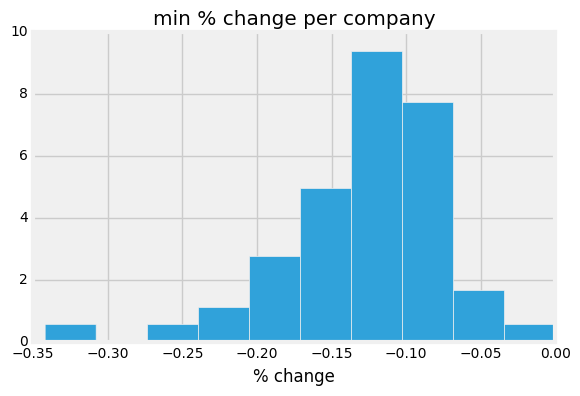

In [14]:
plt.hist(perc_change_desc.loc['min'], normed=True)
plt.title('min % change per company')
plt.xlabel("% change")

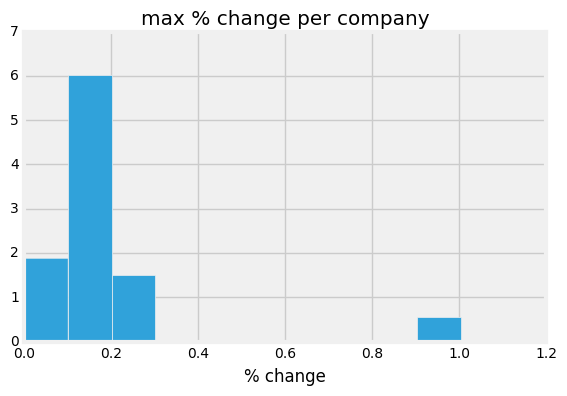

In [15]:
plt.hist(perc_change_desc.loc['max'], normed=True)
plt.title('max % change per company')
plt.xlabel("% change")

Well there is one person that looks suspicious ...

In [16]:
perc_change_desc.iloc[:, (perc_change_desc.loc["max"]>0.9).values]

,EWI,EWT,SH
count,2520.000000,2520.000000,2520.000000
mean,0.000196,0.000578,0.000003
std,0.028807,0.026916,0.023867
min,-0.149548,-0.103405,-0.128128
25%,-0.009975,-0.008387,-0.005882
50%,0.000631,0.000000,-0.000621
75%,0.010576,0.008549,0.004442
max,0.996473,1.003841,0.994977


So in this case it looks like we will be partitioning things on a daily basis type deal. I wonder whether weekends and stuff is going to be problematic but this is probably a minor concern. Perhaps OK for now but keep in mind in case these need changes. My guess is that we don't really want those.

### Starting off with some benchmarks

In [17]:
# compute r_t the vector of the ration between prices at consecutive time-steps
r_t = price_df.pct_change()+1
new_rt = r_t.iloc[1:, :]
new_rt.index = r_t.index[:-1]
rt = new_rt

In [18]:
# Best assets: return on every dollar you put in at t=0
rt.prod().sort_values()[::-1][:10]

IBB    3.533488
XLY    2.142264
EWT    2.097760
XLV    2.044179
XLK    2.026575
XLP    1.931533
IAU    1.807384
GLD    1.789178
XLI    1.784842
IWM    1.721981
dtype: float64

In [19]:
# Worst assets: return on every dollar you put in at t=0
rt.prod().sort_values()[:10]

SDS    0.066567
OIL    0.166575
USO    0.228543
GDX    0.551652
SH     0.594456
FEZ    0.595059
XLF    0.626219
EWU    0.651168
EZU    0.651203
DBC    0.655882
dtype: float64

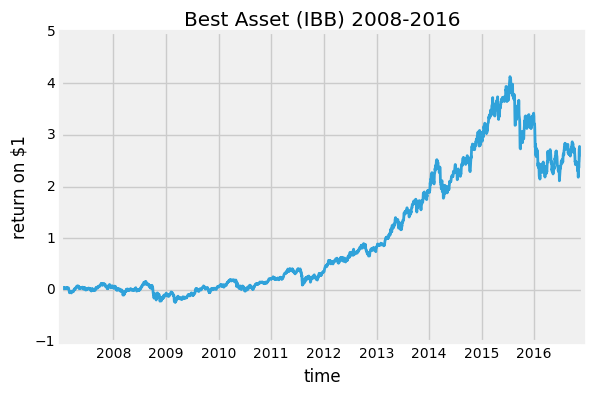

In [20]:
# best asset benchmark for a time period of the whole thing
n = len(assets)
best_asset = np.argmax(price_df.iloc[-1]/price_df.iloc[0])
plt.plot(rt[best_asset].cumprod()-1, lw=2)
plt.title("Best Asset ({}) 2008-2016".format(best_asset))
plt.xlabel("time")
plt.ylabel("return on $1")

In [21]:
# Best Constant Rebalabced Portfolio
b = cvxpy.Variable(n) # the distribution over the assets
constraints = [cvxpy.atoms.sum(b)==1, b>=0] # ensure it is on the simplex
objective = cvxpy.atoms.sum(cvxpy.atoms.log(rt.as_matrix() @ b))
prob = cvxpy.Problem(cvxpy.Maximize(objective), constraints)
np.e**prob.solve()

3.5631479984725525

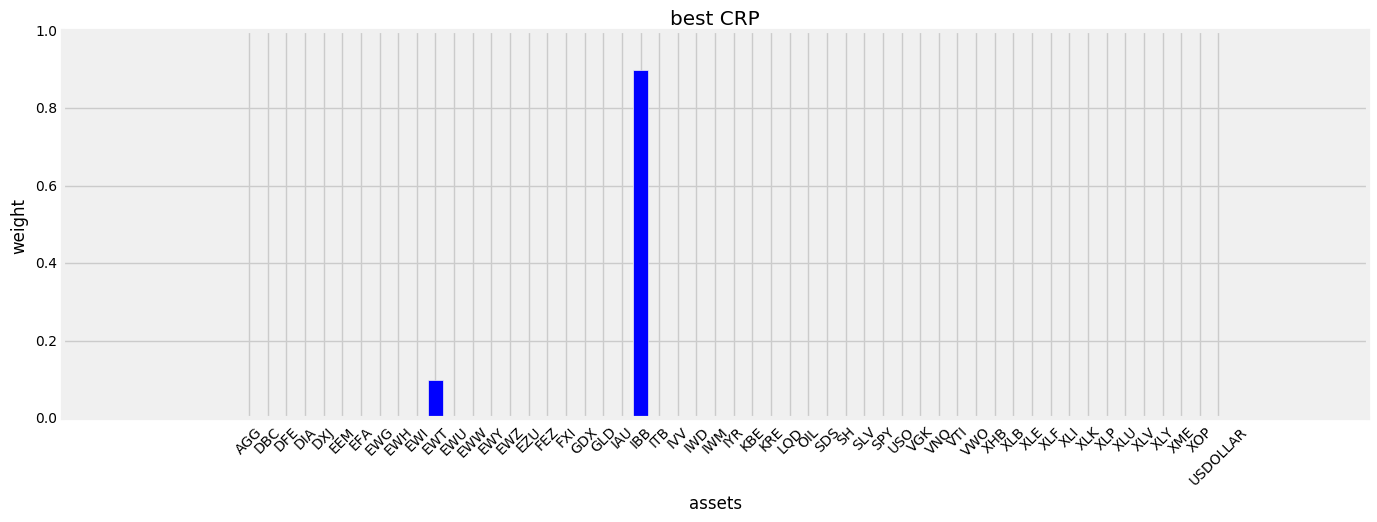

In [22]:
plt.figure(figsize=[15, 5])
plt.bar(np.arange(n)-0.4, np.round(b.value, decimals=5))
_ = plt.xticks(np.arange(n), assets, rotation=45)
plt.title("best CRP")
plt.ylabel("weight")
plt.xlabel("assets")

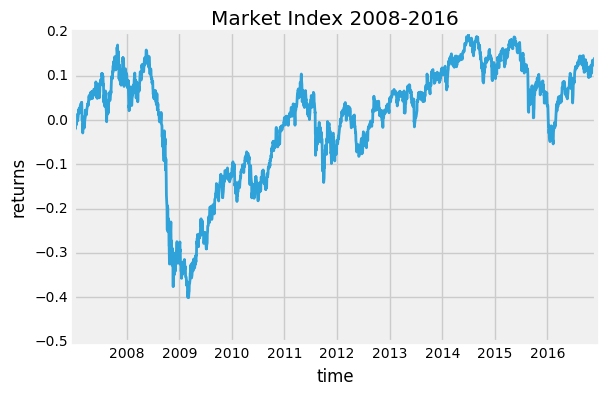

In [23]:
# market index (BUY and HOLD type strategy)
market_index_returns  = (rt.cumprod() * 1/n).sum(1) - 1
plt.plot(market_index_returns, lw=2)
plt.title("Market Index 2008-2016")
plt.xlabel("time")
plt.ylabel("returns")

## Online Gradient Descent Implementation

rt: the vectors given to you at each time step by the environment. Those define the function $f_t = \log x_t^T b_t$

Could use some more thinking as to whether there is a good way to determine $D$ and $G$ assuming you have some historical data available. There are trivial bounds but not sure how useful these would be.


Recall that $\eta_t = \frac{D}{G\sqrt{t}}$ which is what we get as our guarantee. The benchmark we will use is the Best Constant Rebalanced Portfolio.

In [24]:
def project_vector(v):
    proj = cvxpy.Variable(n) # the distribution over the assets
    constraints = [cvxpy.atoms.sum(proj)==1, proj>=0] # ensure it is on the simplex
    objective = cvxpy.atoms.norm(v - proj, p=2)
    prob = cvxpy.Problem(cvxpy.Minimize(objective), constraints).solve()
    
    return proj.value
    
def ogd(b, xt, eta_t):
    """
    Inputs:
            * b: distribution over assets for current time-step
            * xt: current vector of losses
            * eta_t: current learning rate to be used in the update
    Outputs:
            * ret: the return we experienced in that particular round if we had invested 1 dollar
            * b_new: updated distribution over assets that we will be using
    """
    
    ret = np.log(b @ xt) # return a this timestep
    b_new = b + eta_t*(xt/ret) # cause this is gradient ascent really
    
    b_new = project_vector(b_new)
    
    return ret, b_new

In [27]:
b = np.ones(n)/n # we will begin with a uniform distribution over all of our assets
total_return = []

for t in tqdm(np.arange(1, len(rt))):
    
    xt = rt.iloc[t].values # the vector that the
    
    r, b = ogd(b, xt, 1/np.sqrt(t))
    
    total_return.append(r)

100%|██████████| 2519/2519 [00:34<00:00, 73.51it/s]


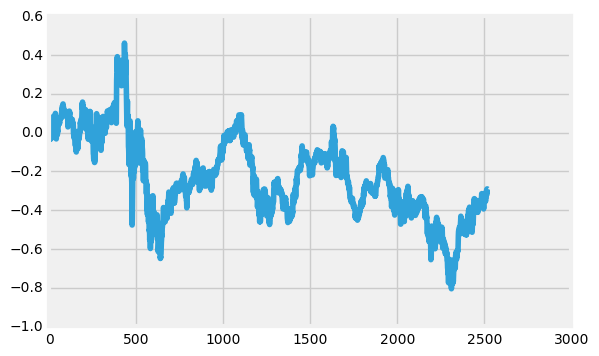

In [29]:
plt.plot(np.cumsum(total_return))

Here we are going to need some first principles to get the derivative of the log returns.

From  first principles (just take a look at $\frac{\partial f}{\partial x_i}$) we can see that the gradient should be $\frac{x_t}{\log x_t^Tb}$.


-------------------- OTHER STUFF --------------------

Suppose we have $f: \mathbb{R}^d \rightarrow \mathbb{R}$.

Then $f(x + \Delta) = f(x) + \frac{\partial f}{\partial x} \Delta + o(||\Delta||)$ where $o(||\Delta||)$ is a term that goes to $0$ faster than $\Delta$ aka it is *any* $r(\Delta)$ s.t. $\frac{r(\Delta)}{||\Delta||} \rightarrow 0$ as $\Delta \rightarrow 0$.
